In [302]:
import sys
sys.path.insert(0, '..')
from lineage import graphs, similarity

In [303]:
import pandas as pd
import os
import networkx as nx

In [308]:
#RESULT_DIR = '/home/suhail/ok/'
RESULT_DIR = '/home/suhail/Projects/sample_workflows/million_notebooks/selected/'

In [309]:
notebooks = [d for d in os.listdir(RESULT_DIR) if os.path.isdir(os.path.join(RESULT_DIR, d))]


In [306]:
notebooks = ['nb_1172641.ipynb',
 'nb_120345.ipynb',
 'nb_264704.ipynb',
 'nb_28174.ipynb',
 'nb_292141.ipynb',
 'nb_315237.ipynb',
 'nb_339588.ipynb',
 'nb_417011.ipynb',
 'nb_422202.ipynb',
 'nb_442286.ipynb',
 'nb_458180.ipynb',
 'nb_495072.ipynb',
 'nb_814615.ipynb']

In [310]:
notebooks

['london-crime',
 'retail',
 'titanic',
 'prop64',
 'churn',
 'agri-mex',
 'githubviz']

In [311]:
from collections import defaultdict
import glob


def get_notebook_artifact_list(nb):
    artifact_dir = RESULT_DIR+nb+'/artifacts/'
    return [os.path.basename(x) for x in glob.glob(artifact_dir+'*.csv')]


def generate_artifact_dict(notebooks):
    notebook_dict = defaultdict(list)
    for nb in notebooks:
        artifacts = frozenset(get_notebook_artifact_list(nb))
        notebook_dict[artifacts].append(nb)
        
    return notebook_dict
        
        
def find_duplicates(artifact_dict):
    return dict(filter(lambda x: len(x[1]) > 1 , artifact_dict.items()))
    

def dedup_notebooks(notebooks):
    artifact_dict = generate_artifact_dict(notebooks)
    final_list = []
    for afs,nbs in artifact_dict.items():
        final_list.append(nbs[0])
        
    return final_list

In [312]:
d_notebooks = dedup_notebooks(notebooks)


In [313]:
from collections import Counter


def get_wrong_edges(exp_graph):
    f_counter = Counter()
    for edge_t in exp_graph.edges(data=True):
        if 'correct' not in exp_graph[edge_t[0]][edge_t[1]]:
            if 'truth' in exp_graph[edge_t[0]][edge_t[1]] and exp_graph[edge_t[0]][edge_t[1]]['truth'] == True:
                if 'operation' in exp_graph[edge_t[0]][edge_t[1]]:
                    f_counter[exp_graph[edge_t[0]][edge_t[1]]['operation']] += 1
                else:
                    f_counter['unknown'] += 1

    return f_counter

In [314]:
from collections import Counter

def get_notebook_result(result_dir, nb, filename='relic_agglomerative_result.csv'):
    return pd.read_csv(result_dir+'/'+nb+'/'+filename, index_col=0)

errors = []
int_columns = ['artifacts', 'columns', 'rows']

def experiment1_results():
    result = pd.DataFrame()
    fcounter = Counter()
    for nb in d_notebooks:
        try:
            nb_result = get_notebook_result(RESULT_DIR,nb).iloc[-1]
            baseline_result = get_notebook_result(RESULT_DIR,nb,filename='baseline_union_result.csv').iloc[-1]
            g = graphs.get_graph(RESULT_DIR,nb)
            artifacts = get_notebook_artifact_list(nb)
            diff = set(g.nodes()).symmetric_difference(set(artifacts))
            print(diff)
            nb_result['files'] = len(artifacts)
            nb_result['symdiff'] = len(diff)
            nb_result['gt_comp'] = len([x for x in nx.weakly_connected_components(g)])
            baseline_result['files'] = len(artifacts)
            baseline_result['symdiff'] = len(diff)
            baseline_result['gt_comp'] = len([x for x in nx.weakly_connected_components(g)])
            result = result.append(nb_result)
            result = result.append(baseline_result)
            # find the operations that are worst offenders
            g_truth = graphs.get_graph(RESULT_DIR, nb)
            g_infered = graphs.get_graph_edge_list(RESULT_DIR, nb, 'cell')
            dist = graphs.get_distance_matrix(RESULT_DIR, nb, 'cell')
            exp_graph = graphs.generate_explaination_graph(g_truth, g_infered, dist)
            fcounter += get_wrong_edges(exp_graph)
        except FileNotFoundError as e:
            errors.append(nb)
            #print(e)
            pass
    return result.astype({x:'int64' for x in int_columns})



def experiment2_results():
    result = pd.DataFrame()
    for nb in notebooks:
        try:
            
            result = result.append(get_notebook_result(RESULT_DIR,nb, filename='relic_thresholding_final_result.csv'))

        except FileNotFoundError as e:
            errors.append(nb)
            raise
    return result.astype({x:'int64' for x in int_columns})


def experiment3_results():
    result = pd.DataFrame()
    
    metrics = ['cell', 'col', 'valset', 'ivalset', 'colvalset', 'cellvalset']
    
    for nb in notebooks:
        try:
            for metric in metrics:
                result = result.append(get_notebook_result(RESULT_DIR,nb, filename='relic_thresholding_final_result_'+metric+'.csv'), ignore_index=True)

        except FileNotFoundError as e:
            errors.append(nb)
            raise
    return result.astype({x:'int64' for x in int_columns})

In [323]:
from collections import Counter

def get_notebook_result(result_dir, nb, filename='relic_agglomerative_result.csv'):
    return pd.read_csv(result_dir+'/'+nb+'/'+filename, index_col=0)

errors = []
int_columns = ['artifacts', 'columns', 'rows']

def experiment1_results():
    result = pd.DataFrame()
    fcounter = Counter()
    for nb in d_notebooks:
        try:
            cell_result = get_notebook_result(RESULT_DIR,nb, filename='cell_relic_result.csv').iloc[-1]
            col_result = get_notebook_result(RESULT_DIR,nb,filename='col_relic_result.csv').iloc[-1]
            pc2_cellcol_result = get_notebook_result(RESULT_DIR,nb,filename='pc2cellcol_relic_result.csv').iloc[-1]
            pc2_colcell_result = get_notebook_result(RESULT_DIR,nb,filename='pc2colcell_relic_result.csv').iloc[-1]
            valset_result = get_notebook_result(RESULT_DIR,nb,filename='valset_relic_result.csv').iloc[-1]
            rowvalset_result = get_notebook_result(RESULT_DIR,nb,filename='rowvalset_relic_result.csv').iloc[-1]
            colvalset_result = get_notebook_result(RESULT_DIR,nb,filename='colvalset_relic_result.csv').iloc[-1]
            cellvalset_result = get_notebook_result(RESULT_DIR,nb,filename='cellvalset_relic_result.csv').iloc[-1]
            cell_result = get_notebook_result(RESULT_DIR,nb, filename='cell_relic_result.csv').iloc[-1]
            cellgroup_result = get_notebook_result(RESULT_DIR,nb, filename='cell+group_relic_result.csv').iloc[-1]

            g = graphs.get_graph(RESULT_DIR,nb)
            artifacts = get_notebook_artifact_list(nb)
            diff = set(g.nodes()).symmetric_difference(set(artifacts))
            
            combined = pd.DataFrame()
            combined = combined.append([cell_result,col_result,pc2_cellcol_result, pc2_colcell_result, valset_result, rowvalset_result, colvalset_result, cellvalset_result, cellgroup_result])
            combined['files'] = len(artifacts)
            combined['symdiff'] = len(diff)
            combined['gt_comp'] = len([x for x in nx.weakly_connected_components(g)])
            isdag = nx.is_directed_acyclic_graph(g)
            combined['isdag'] = isdag
            if isdag:
                combined['pathlen'] = nx.dag_longest_path_length(g)
            
            result = result.append(combined)

            # find the operations that are worst offenders
            g_truth = graphs.get_graph(RESULT_DIR, nb)
            g_infered = graphs.get_graph_edge_list(RESULT_DIR, nb, 'cell')
            dist = graphs.get_distance_matrix(RESULT_DIR, nb, 'cell')
            exp_graph = graphs.generate_explaination_graph(g_truth, g_infered, dist)
            fcounter += get_wrong_edges(exp_graph)
        
        except FileNotFoundError as e:
            errors.append(nb)
            print(e)
            pass
    
    return result

In [343]:
result = experiment1_results()
result = result.replace('ivalset', 'rowvalset')

In [339]:
errors

[]

In [139]:
# Sample Notebooks that are DAGs
new_sample = set(result.loc[(result.isdag == True) & (result.pathlen >= 3) & (result.symdiff == 0) & (result.gt_comp == 1)].nb_name.values)
new_sample

{'agri-mex', 'githubviz', 'london-crime', 'prop64', 'retail', 'titanic'}

In [140]:
len(new_sample)

6

In [141]:
new_results = result.loc[result.nb_name.isin(new_sample)]
new_results

,nb_name,rows,columns,artifacts,index,numclusters,distance_metric,edges_correct,edges_missing,edges_to_remove,...,recall,F1,missing_files,time,pre_cluster,files,symdiff,gt_comp,isdag,pathlen
0,london-crime,446169,5,16,False,8,cell,11,5,4,...,0.733333,0.709677,0,29.858100,No Precluster,16,0,1,True,5
0,london-crime,446169,5,16,False,8,col,14,2,1,...,0.933333,0.903226,0,0.939017,No Precluster,16,0,1,True,5
7,london-crime,446169,5,16,False,8,pc2cellcol,13,3,2,...,0.866667,0.838710,0,1.479498,PC2,16,0,1,True,5
7,london-crime,446169,5,16,False,8,pc2colcell,13,3,2,...,0.866667,0.838710,0,1.989568,PC2,16,0,1,True,5
0,london-crime,446169,5,16,False,8,valset,12,4,3,...,0.800000,0.774194,0,0.861551,No Precluster,16,0,1,True,5
0,london-crime,446169,5,16,False,8,ivalset,9,7,6,...,0.600000,0.580645,0,0.854265,No Precluster,16,0,1,True,5
0,london-crime,446169,5,16,False,8,colvalset,14,2,1,...,0.933333,0.903226,0,0.839972,No Precluster,16,0,1,True,5
0,retail,17379,16,21,False,9,cell,12,8,8,...,0.600000,0.600000,0,66.038282,No Precluster,21,0,1,True,4
0,retail,17379,16,21,False,9,col,15,5,5,...,0.750000,0.750000,0,0.479922,No Precluster,21,0,1,True,4
8,retail,17379,16,21,False,9,pc2cellcol,14,6,6,...,0.700000,0.700000,0,1.003363,PC2,21,0,1,True,4


In [344]:
ok_sample = ['nb_668735.ipynb',
'nb_292141.ipynb',
'nb_1127960.ipynb',
'nb_339588.ipynb',
'nb_391713.ipynb',
'nb_1183746.ipynb',
'nb_1048957.ipynb',
'nb_213583.ipynb',
'nb_180346.ipynb',
'nb_458180.ipynb']

#sample_baselines = result[result.nb_name.isin(ok_sample)]
#sample_baselines['method'] = sample_baselines['distance_metric'].apply(lambda x: 'relic' if x=='pandas_cell' else 'baseline')
sample_baselines = result
#sample_baselines = result.loc[result.distance_metric.isin(['cell','colvalset', 'valset', 'ivalset'])]
#sample_baselines = result.loc[result.distance_metric.isin(['cellvalset','colvalset', 'valset', 'ivalset'])]
#sample_baselines = sample_baselines.replace('ivalset', 'rowvalset')

In [336]:
result

,nb_name,rows,columns,artifacts,index,numclusters,distance_metric,edges_correct,edges_missing,edges_to_remove,...,recall,F1,missing_files,time,pre_cluster,files,symdiff,gt_comp,isdag,pathlen
0,london-crime,446169,5,16,False,8,cell,8,8,0,...,0.500000,0.666667,0,37.139649,No Precluster,16,0,1,True,5
0,london-crime,446169,5,16,False,8,col,14,2,1,...,0.875000,0.903226,0,0.863777,No Precluster,16,0,1,True,5
7,london-crime,446169,5,16,False,8,pc2cellcol,13,3,2,...,0.866667,0.838710,0,1.479498,PC2,16,0,1,True,5
7,london-crime,446169,5,16,False,8,pc2colcell,13,3,2,...,0.866667,0.838710,0,1.989568,PC2,16,0,1,True,5
0,london-crime,446169,5,16,False,8,valset,12,4,3,...,0.750000,0.774194,0,0.862574,No Precluster,16,0,1,True,5
0,london-crime,446169,5,16,False,8,rowvalset,9,7,6,...,0.562500,0.580645,0,0.841364,No Precluster,16,0,1,True,5
0,london-crime,446169,5,16,False,8,colvalset,14,2,1,...,0.875000,0.903226,0,0.852544,No Precluster,16,0,1,True,5
0,london-crime,446169,5,16,False,8,cellvalset,12,4,3,...,0.750000,0.774194,0,0.859100,No Precluster,16,0,1,True,5
7,london-crime,446169,5,16,False,8,cell+group,15,1,0,...,0.937500,0.967742,0,32.817312,No Precluster,16,0,1,True,5
0,retail,17379,16,21,False,9,cell,12,8,8,...,0.600000,0.600000,0,89.345083,No Precluster,21,0,1,True,4


(0.0, 1.0)

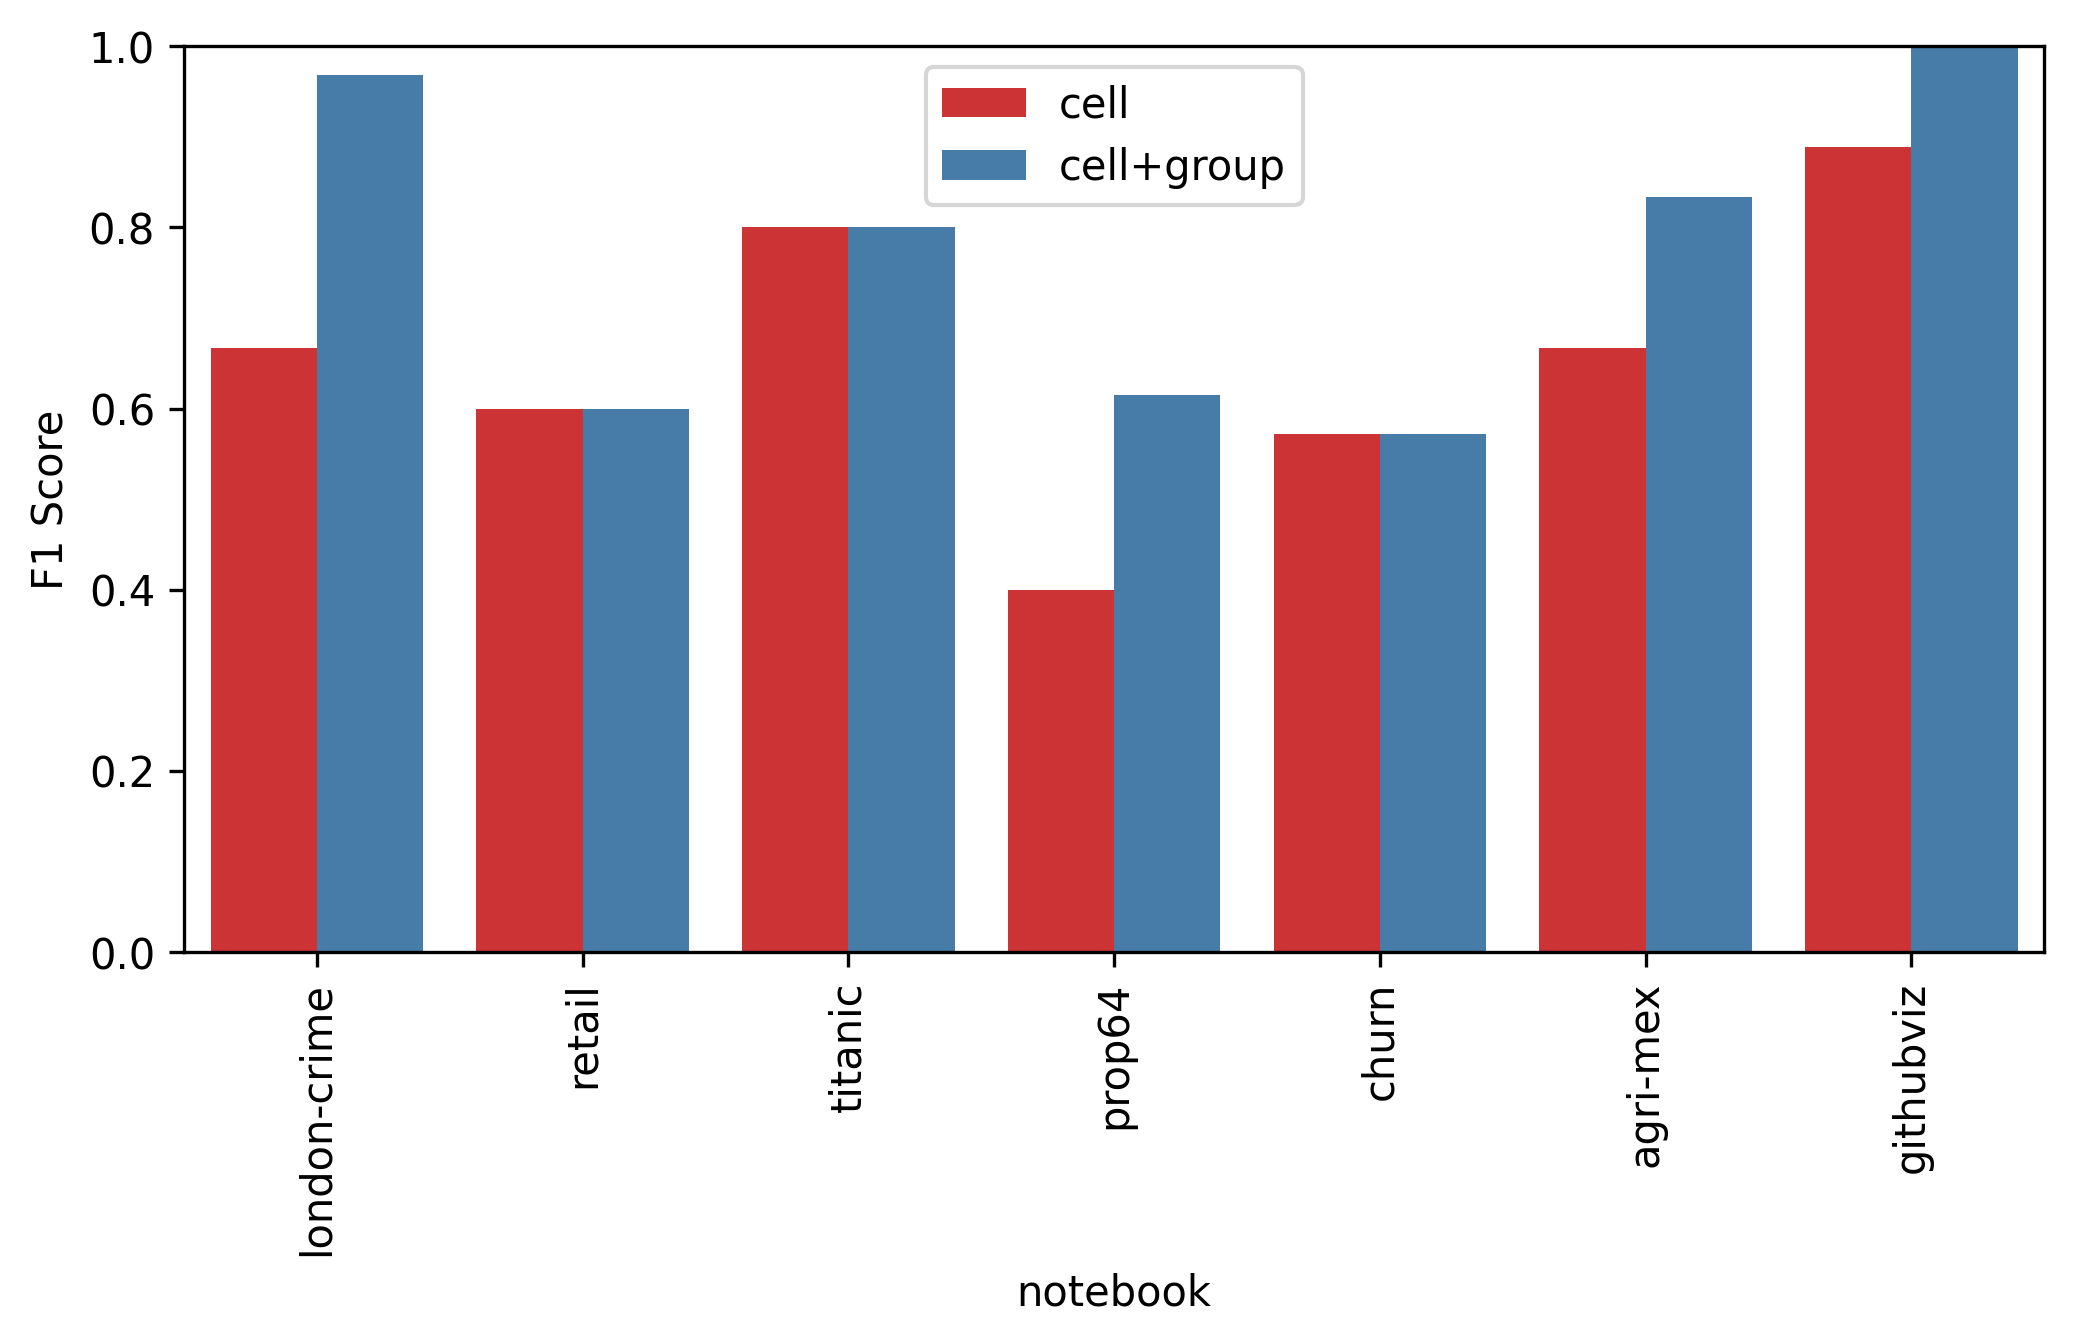

In [345]:
# library and dataset
import seaborn as sns
import matplotlib.pyplot as plt


fig = plt.figure(num=None, figsize=(8, 4), dpi=300, facecolor='w', edgecolor='k')
 
# Grouped boxplot
chart = sns.barplot(x=sample_baselines.nb_name, y="F1", hue="distance_metric", data=sample_baselines, palette="Set1",
                   hue_order=['cell', 'cell+group'])

chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.legend(loc='best')
plt.xlabel('notebook')
plt.ylabel('F1 Score')
plt.ylim(0,1.0)


In [328]:
# library and dataset
import seaborn as sns
import matplotlib.pyplot as plt

#Experiment 3
sample_baselines = result.loc[result.distance_metric.isin(['cellvalset','colvalset', 'valset', 'rowvalset'])]
#sample_baselines = result
sample_baselines = sample_baselines.replace('ivalset', 'rowvalset')

 
# Grouped boxplot

for nb in notebooks:
    for measure in ['F1', 'precision', 'recall']:
        nb_result = sample_baselines.loc[sample_baselines.nb_name == nb]
        fig = plt.figure(num=None, figsize=(8, 4), dpi=100, facecolor='w', edgecolor='k')
        chart = sns.lineplot(x="threshold", y=measure, hue="distance_metric", data=nb_result, palette="Set1", markers=True, style="distance_metric")

        plt.legend(loc='best')
        #plt.xlabel('threshold')
        plt.title(nb+' ('+str(len(graphs.get_graph(RESULT_DIR, nb).edges()))+ ' edges)')
        plt.ylabel(measure)
        plt.ylim(0,1.0)



ValueError: Could not interpret input 'threshold'

<Figure size 800x400 with 0 Axes>

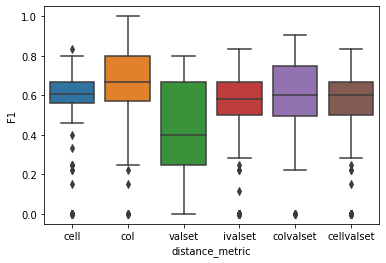

In [247]:
sns.boxplot(x='distance_metric', y='F1', data=result)

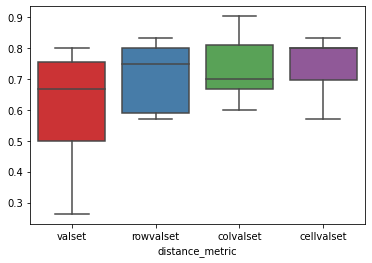

In [252]:
grouped = sample_baselines.groupby(['nb_name','distance_metric']).max()
unstacked = grouped[['F1']].unstack()
#sns.boxplot(data=unstacked)
unstacked.columns = unstacked.columns.droplevel()
sns.boxplot(data=unstacked, palette='Set1', order=['valset','rowvalset','colvalset', 'cellvalset'])

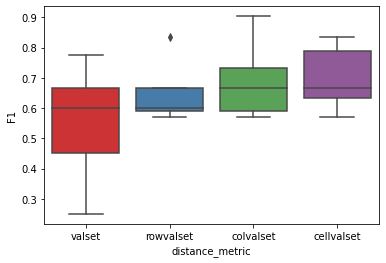

In [269]:
lowest = result.loc[result.threshold == 0]
#unstacked = grouped[['F1']].unstack()
#sns.boxplot(data=unstacked)
#unstacked.columns = unstacked.columns.droplevel()
lowest
sns.boxplot(x='distance_metric', y='F1', data=lowest, palette='Set1', order=['valset','rowvalset','colvalset', 'cellvalset'])

In [274]:
lowest

,F1,artifacts,columns,distance_metric,edges_correct,edges_missing,edges_to_remove,index,join_edges,missing_files,nb_name,numclusters,pre_cluster,precision,recall,rows,threshold,time
0,0.709677,16,5,cell,11.0,5.0,4.0,0.0,NaN,0.0,london-crime,8.0,No Precluster,0.733333,0.687500,446169,0.0,43.439336
20,0.903226,16,5,col,14.0,2.0,1.0,0.0,NaN,0.0,london-crime,8.0,No Precluster,0.933333,0.875000,446169,0.0,0.864265
40,0.774194,16,5,valset,12.0,4.0,3.0,0.0,NaN,0.0,london-crime,8.0,No Precluster,0.800000,0.750000,446169,0.0,0.862285
60,0.580645,16,5,rowvalset,9.0,7.0,6.0,0.0,NaN,0.0,london-crime,8.0,No Precluster,0.600000,0.562500,446169,0.0,0.854956
80,0.903226,16,5,colvalset,14.0,2.0,1.0,0.0,NaN,0.0,london-crime,8.0,No Precluster,0.933333,0.875000,446169,0.0,0.886470
100,0.774194,16,5,cellvalset,12.0,4.0,3.0,0.0,NaN,0.0,london-crime,8.0,No Precluster,0.800000,0.750000,446169,0.0,0.863440
120,0.600000,21,16,cell,12.0,8.0,8.0,0.0,NaN,0.0,retail,9.0,No Precluster,0.600000,0.600000,17379,0.0,101.384827
140,0.750000,21,16,col,15.0,5.0,5.0,0.0,NaN,0.0,retail,9.0,No Precluster,0.750000,0.750000,17379,0.0,0.458535
160,0.250000,21,16,valset,5.0,15.0,15.0,0.0,NaN,0.0,retail,9.0,No Precluster,0.250000,0.250000,17379,0.0,0.462396
180,0.600000,21,16,rowvalset,12.0,8.0,8.0,0.0,NaN,0.0,retail,9.0,No Precluster,0.600000,0.600000,17379,0.0,0.450983


In [171]:
sample_baselines.loc[sample_baselines.nb_name == nb]

,F1,artifacts,columns,distance_metric,edges_correct,edges_missing,edges_to_remove,index,join_edges,missing_files,nb_name,numclusters,pre_cluster,precision,recall,rows,threshold,time
0,0.709677,16,5,cell,11.0,5.0,4.0,0.0,NaN,0.0,london-crime,8.0,No Precluster,0.6875,0.733333,446169,0.00,42.759626
1,0.571429,16,5,cell,8.0,8.0,4.0,0.0,NaN,0.0,london-crime,8.0,No Precluster,0.5000,0.666667,446169,0.05,0.954413
2,0.666667,16,5,cell,8.0,8.0,0.0,0.0,NaN,0.0,london-crime,8.0,No Precluster,0.5000,1.000000,446169,0.10,0.869419
3,0.666667,16,5,cell,8.0,8.0,0.0,0.0,NaN,0.0,london-crime,8.0,No Precluster,0.5000,1.000000,446169,0.15,0.862188
4,0.666667,16,5,cell,8.0,8.0,0.0,0.0,NaN,0.0,london-crime,8.0,No Precluster,0.5000,1.000000,446169,0.20,0.827485
5,0.666667,16,5,cell,8.0,8.0,0.0,0.0,NaN,0.0,london-crime,8.0,No Precluster,0.5000,1.000000,446169,0.25,0.855924
6,0.666667,16,5,cell,8.0,8.0,0.0,0.0,NaN,0.0,london-crime,8.0,No Precluster,0.5000,1.000000,446169,0.30,0.854481
7,0.666667,16,5,cell,8.0,8.0,0.0,0.0,NaN,0.0,london-crime,8.0,No Precluster,0.5000,1.000000,446169,0.35,0.854207
8,0.666667,16,5,cell,8.0,8.0,0.0,0.0,NaN,0.0,london-crime,8.0,No Precluster,0.5000,1.000000,446169,0.40,0.833366
9,0.666667,16,5,cell,8.0,8.0,0.0,0.0,NaN,0.0,london-crime,8.0,No Precluster,0.5000,1.000000,446169,0.45,0.862440


In [416]:
result.loc[result.isdag == True].sort_values('pathlen')

,nb_name,rows,columns,artifacts,index,numclusters,distance_metric,edges_correct,edges_missing,edges_to_remove,...,recall,F1,missing_files,time,pre_cluster,files,symdiff,gt_comp,isdag,pathlen
0,nb_123698.ipynb,5000,9,7,False,4,cell,0,0,6,...,0.000000,0.000000,0,0.088841,No Precluster,7,6,1,True,0.0
2,nb_138215.ipynb,33,1,6,False,5,pc2colcell,0,0,2,...,0.000000,0.000000,0,0.051398,PC2,6,4,2,True,0.0
2,nb_138215.ipynb,33,1,6,False,5,pc2cellcol,0,0,2,...,0.000000,0.000000,0,0.042695,PC2,6,4,2,True,0.0
0,nb_138215.ipynb,33,1,6,False,5,col,0,0,5,...,0.000000,0.000000,0,0.016623,No Precluster,6,4,2,True,0.0
0,nb_138215.ipynb,33,1,6,False,5,cell,0,0,5,...,0.000000,0.000000,0,0.023075,No Precluster,6,4,2,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,nb_118732.ipynb,49,1,18,False,11,cell,6,6,11,...,0.352941,0.413793,0,0.250968,No Precluster,18,4,2,True,5.0
1,nb_120345.ipynb,90734,21,11,False,2,pc2cellcol,7,7,1,...,0.875000,0.636364,0,3.576903,PC2,11,0,1,True,8.0
0,nb_120345.ipynb,90734,21,11,False,2,col,6,8,1,...,0.857143,0.571429,0,3.496959,No Precluster,11,0,1,True,8.0
0,nb_120345.ipynb,90734,21,11,False,2,cell,7,7,1,...,0.875000,0.636364,0,30.856354,No Precluster,11,0,1,True,8.0


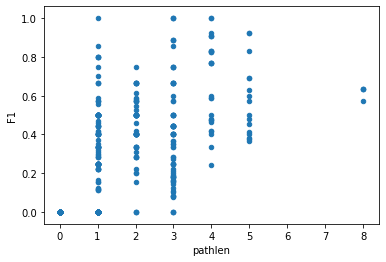

In [417]:
result.loc[result.isdag == True].plot.scatter('pathlen','F1')

Text(0, 0.5, 'F1 Score')

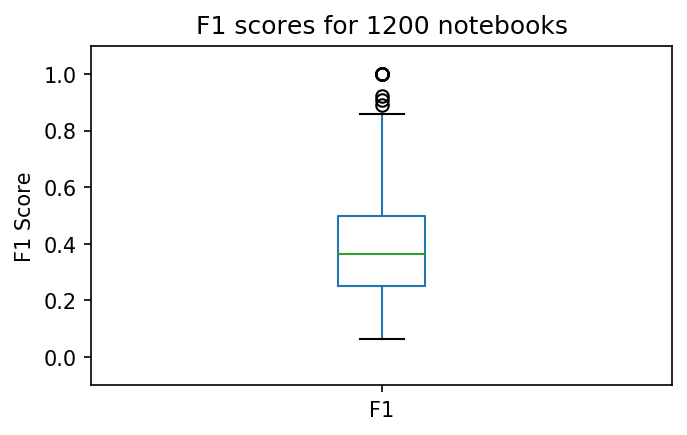

In [139]:
import matplotlib.pyplot as plt 
fig = plt.figure(num=None, figsize=(5,3), dpi=150, facecolor='w', edgecolor='k')

ax = result[result.F1 > 0 ]['F1'].plot.box('F1')
plt.ylim(-0.1,1.1)
plt.title('F1 scores for '+str(len(result.index))+' notebooks')
ax.set_ylabel('F1 Score')

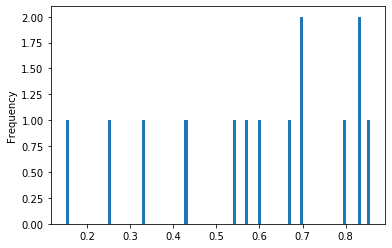

In [19]:
result['F1'].plot.hist(bins=100)

In [20]:
cleaner = result[(result.symdiff == 0) & (result.gt_comp == 1)]
cleaner

,F1,Unnamed: 0,artifacts,columns,distance_metric,edges_correct,edges_missing,edges_to_remove,files,gt_comp,...,join_edges,missing_files,nb_name,numclusters,pre_cluster,precision,recall,rows,symdiff,time
8,0.800000,8.0,18,5,pandas_cell,12.0,6.0,0.0,18.0,1.0,...,NaN,0.0,london-crime,8.0,PC2,0.666667,1.000000,446169,0.0,22.470568
0,0.857143,0.0,18,5,pandas_col,15.0,3.0,2.0,18.0,1.0,...,NaN,0.0,nb_331056.ipynb,8.0,No Preclustering,0.833333,0.882353,446169,0.0,5.526874
8,0.700000,8.0,21,16,pandas_cell,14.0,6.0,6.0,21.0,1.0,...,NaN,0.0,retail,9.0,PC2,0.700000,0.700000,17379,0.0,29.700569
0,0.150000,0.0,21,16,pandas_col,3.0,17.0,17.0,21.0,1.0,...,NaN,0.0,retail,9.0,No Preclustering,0.150000,0.150000,17379,0.0,9.881040
8,0.700000,8.0,13,12,pandas_cell,7.0,5.0,1.0,13.0,1.0,...,NaN,0.0,titanic,9.0,PC2,0.583333,0.875000,891,0.0,2.469796
0,0.250000,0.0,13,12,pandas_col,3.0,9.0,9.0,13.0,1.0,...,NaN,0.0,titanic,9.0,No Preclustering,0.250000,0.250000,891,0.0,0.305215
1,0.545455,1.0,8,13,pandas_cell,3.0,4.0,1.0,8.0,1.0,...,NaN,0.0,prop64,4.0,PC2,0.428571,0.750000,56379,0.0,1.891196
0,0.428571,0.0,8,13,pandas_col,3.0,4.0,4.0,8.0,1.0,...,NaN,0.0,nb_495072.ipynb,4.0,No Preclustering,0.428571,0.428571,56379,0.0,0.523088
2,0.571429,2.0,6,21,pandas_cell,2.0,3.0,0.0,6.0,1.0,...,NaN,0.0,churn,5.0,PC2,0.400000,1.000000,3333,0.0,0.439951
0,0.600000,0.0,6,21,pandas_col,3.0,2.0,2.0,6.0,1.0,...,NaN,0.0,churn,5.0,No Preclustering,0.600000,0.600000,3333,0.0,0.102783


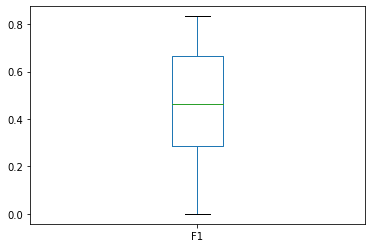

In [62]:
cleaner['F1'].plot.box()

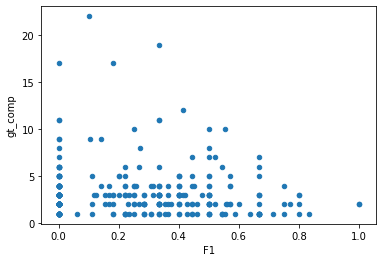

In [63]:
result.plot.scatter('F1','gt_comp')

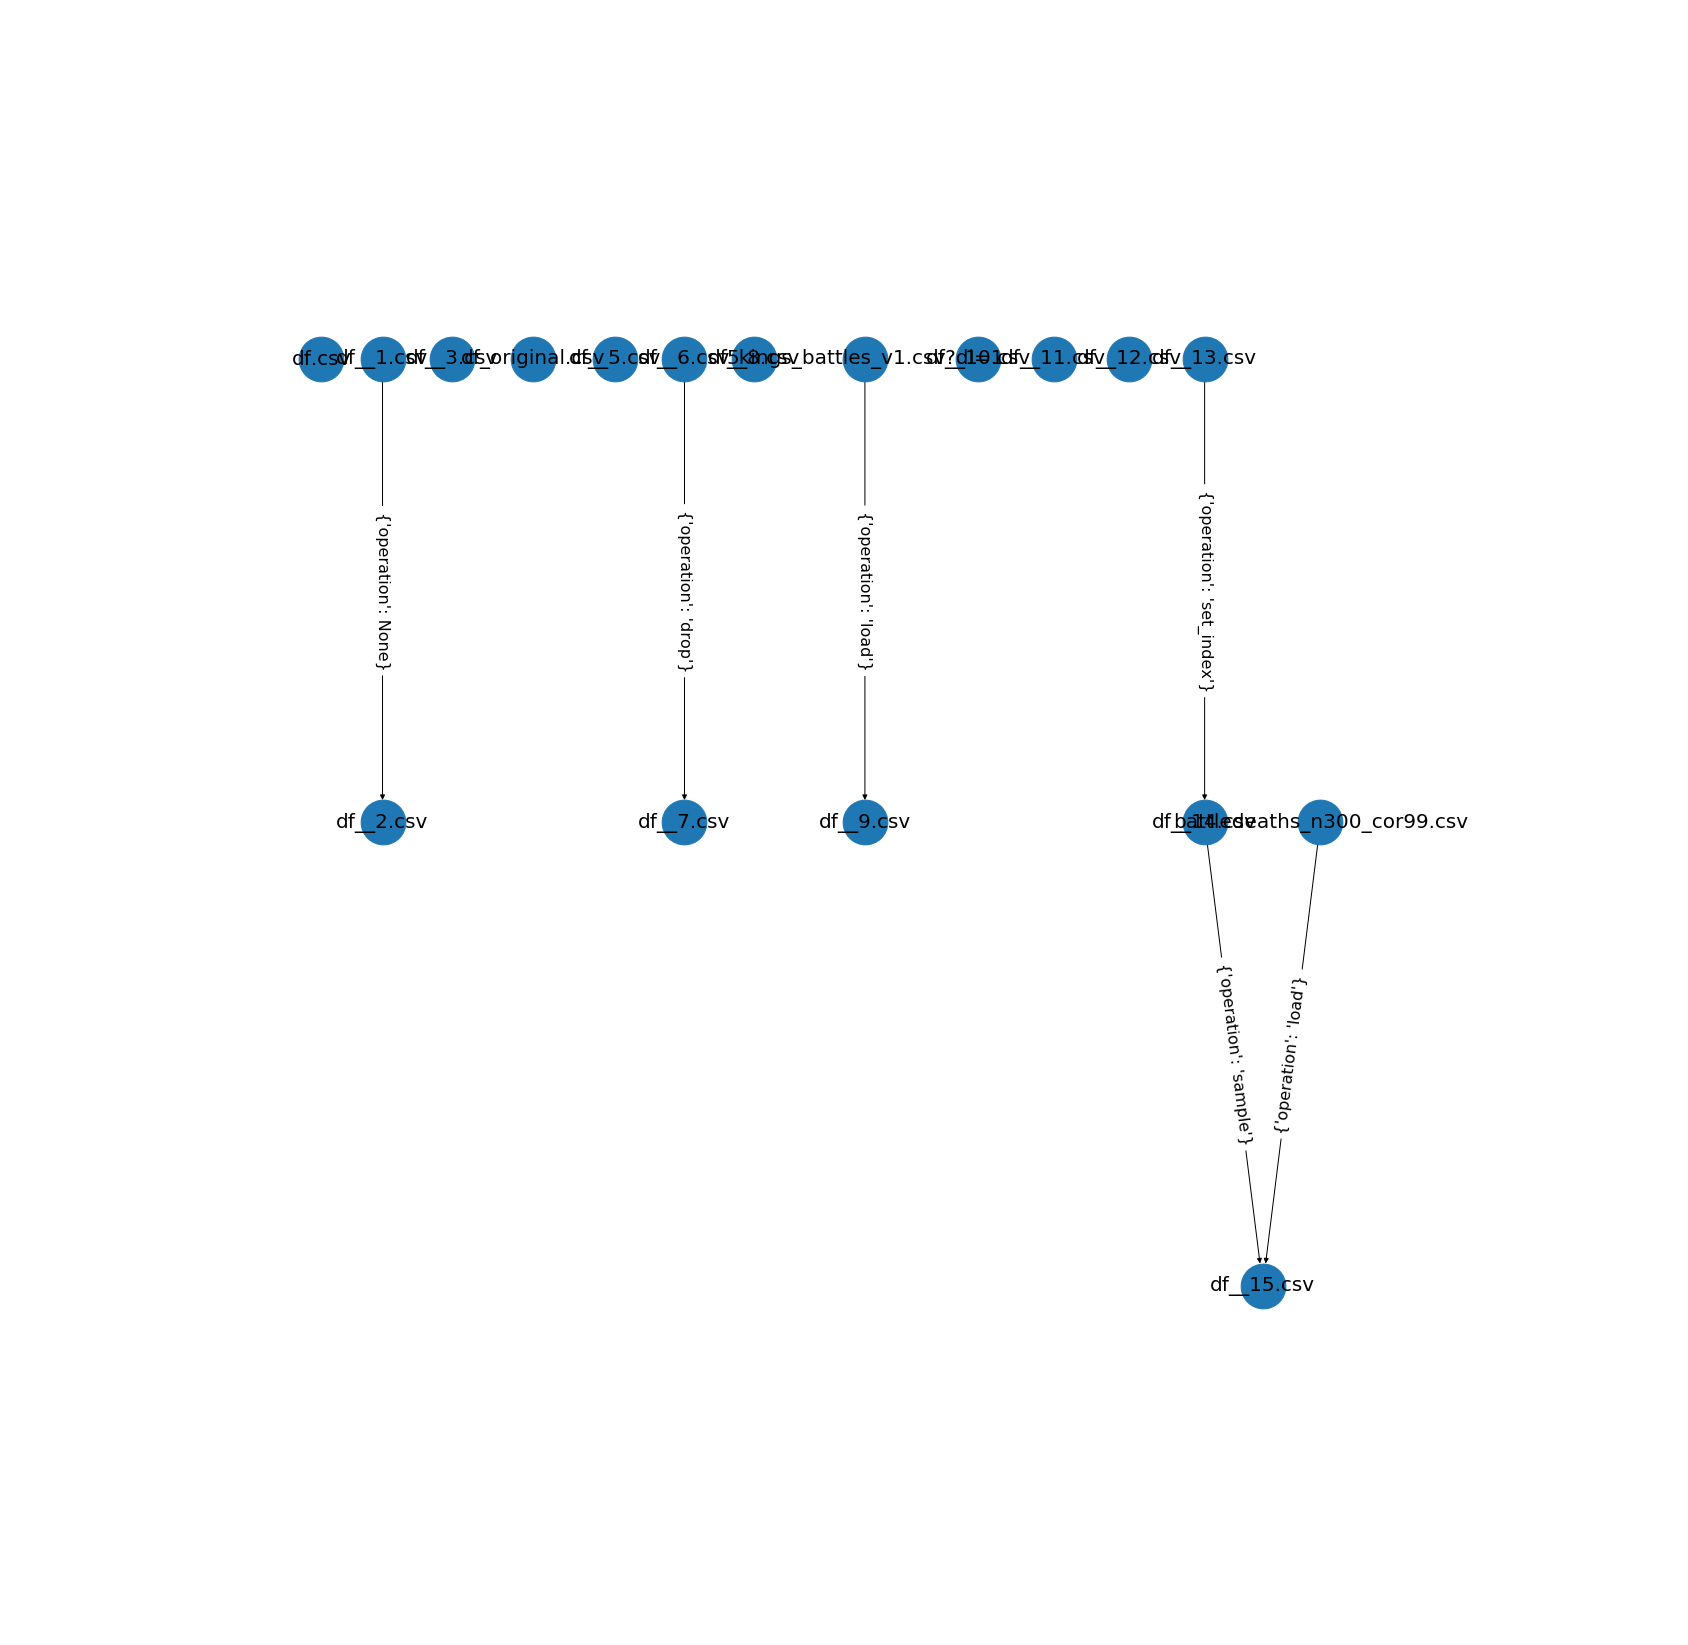

<module 'matplotlib.pyplot' from '/home/suhail/anaconda3/envs/relic/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [64]:
g = graphs.get_graph(RESULT_DIR,'nb_1026631.ipynb')
graphs.draw_graph(g, canvas_size=(30,30))

In [101]:
import networkx as nx
nx.drawing.nx_pydot.write_dot(g, 'test.dot')

In [42]:
get_notebook_artifact_list('nb_1195712.ipynb')

['/home/suhail/ok/nb_1195712.ipynb/artifacts/df.csv',
 '/home/suhail/ok/nb_1195712.ipynb/artifacts/test.csv',
 '/home/suhail/ok/nb_1195712.ipynb/artifacts/titanic.csv',
 '/home/suhail/ok/nb_1195712.ipynb/artifacts/train.csv',
 '/home/suhail/ok/nb_1195712.ipynb/artifacts/submission.csv',
 '/home/suhail/ok/nb_1195712.ipynb/artifacts/X_train.csv',
 '/home/suhail/ok/nb_1195712.ipynb/artifacts/X_test.csv']

In [122]:
errors

['nb_1026631.ipynb',
 'nb_665007.ipynb',
 'nb_165281.ipynb',
 'nb_212182.ipynb',
 'nb_158183.ipynb',
 'nb_23353.ipynb',
 'nb_422665.ipynb',
 'nb_1099234.ipynb',
 'nb_739891.ipynb',
 'nb_266913.ipynb',
 'nb_201646.ipynb',
 'nb_661088.ipynb']

In [26]:
import json
import os

def find_downloaded_csvs():
    result = pd.DataFrame()
    for nb in notebooks:
        metadata_file = RESULT_DIR+nb+'/run_metadata.json'
        with open(metadata_file) as json_file:
            data = json.load(json_file)
            for cell in data:
                if 'links' in cell:
                    #print(cell['links'])
                    for filename in cell['links'].keys():
                        full_path = RESULT_DIR+nb+'/artifacts/'+filename
                        if os.path.exists(full_path):
                            #print(cell['links'])
                            try:
                                os.remove(full_path)
                            except IsADirectoryError as e:
                                pass
                        
                        g = graphs.get_graph(RESULT_DIR,nb)
                        
                        if filename in g.nodes():
                            g.remove_node(filename)
                            outfile = RESULT_DIR+nb+'/'+nb+'_gt_fixed.pkl'
                            nx.write_gpickle(g, outfile)
            

In [27]:
find_downloaded_csvs()

In [127]:
sample = result.sample(20)
sample

,F1,Unnamed: 0,artifacts,columns,distance_metric,edges_correct,edges_missing,edges_to_remove,files,gt_comp,...,join_edges,missing_files,nb_name,numclusters,pre_cluster,precision,recall,rows,symdiff,time
6,0.600000,6.0,7,15,pandas_cell,3.0,1.0,3.0,7.0,2.0,...,NaN,0.0,nb_668735.ipynb,7.0,PC2,0.750000,0.500000,891,1.0,0.270027
3,0.000000,3.0,7,3,pandas_cell,0.0,4.0,3.0,7.0,6.0,...,NaN,0.0,nb_324400.ipynb,6.0,PC2,0.000000,0.000000,275982,0.0,4.214252
3,0.222222,3.0,18,3,pandas_cell,3.0,15.0,6.0,18.0,3.0,...,NaN,0.0,nb_423587.ipynb,9.0,PC2,0.166667,0.333333,7,1.0,1.729499
2,0.400000,2.0,5,5,pandas_cell,1.0,0.0,3.0,5.0,3.0,...,NaN,0.0,nb_292141.ipynb,3.0,PC2,1.000000,0.250000,6,1.0,0.169317
4,0.400000,4.0,9,64,pandas_cell,2.0,4.0,2.0,9.0,5.0,...,NaN,0.0,nb_923025.ipynb,7.0,PC2,0.333333,0.500000,357,1.0,1.069518
7,0.235294,7.0,8,17,pandas_cell,2.0,8.0,5.0,8.0,1.0,...,NaN,0.0,nb_1127960.ipynb,8.0,PC2,0.200000,0.285714,4119,0.0,1.258747
1,0.333333,1.0,5,7,pandas_cell,1.0,1.0,3.0,5.0,2.0,...,NaN,0.0,nb_339588.ipynb,2.0,PC2,0.500000,0.250000,80,1.0,0.122177
2,0.000000,2.0,7,5,pandas_cell,0.0,4.0,2.0,7.0,2.0,...,NaN,0.0,nb_391713.ipynb,2.0,PC2,0.000000,0.000000,4622,2.0,0.288837
3,0.571429,3.0,12,15,pandas_cell,4.0,3.0,3.0,12.0,5.0,...,NaN,0.0,nb_747796.ipynb,7.0,PC2,0.571429,0.571429,50,3.0,1.673882
1,0.000000,1.0,5,10,pandas_cell,0.0,2.0,2.0,5.0,2.0,...,NaN,0.0,nb_1201018.ipynb,3.0,PC2,0.000000,0.000000,214,2.0,0.094446


In [129]:
sample.nb_name.to_csv('20200218_sample.csv')

/home/suhail/anaconda3/envs/relic/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [133]:
#sample.to_csv('20200218_sample_scores.csv')

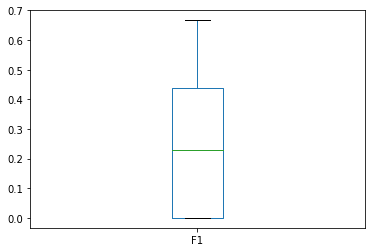

In [134]:
sample['F1'].plot.box()

In [135]:
result.F1.mean()

0.26060177180370847

In [139]:
sample[sample.nb_name== 'nb_75676.ipynb']

,F1,Unnamed: 0,artifacts,columns,distance_metric,edges_correct,edges_missing,edges_to_remove,files,gt_comp,...,join_edges,missing_files,nb_name,numclusters,pre_cluster,precision,recall,rows,symdiff,time
6,0.166667,6.0,13,4,pandas_cell,2.0,10.0,10.0,12.0,4.0,...,NaN,1.0,nb_75676.ipynb,7.0,PC2,0.166667,0.166667,3,4.0,2.091926


In [106]:
sample = pd.read_csv('20200218_sample_scores.csv')
sample_baselines = result[result.nb_name.isin(sample.nb_name)]

In [357]:
nb_list = sample_baselines.nb_name.unique()
nb_list

array(['nb_1048957.ipynb', 'nb_292141.ipynb', 'nb_180346.ipynb',
       'nb_213583.ipynb', 'nb_391713.ipynb', 'nb_339588.ipynb',
       'nb_1183746.ipynb', 'nb_668735.ipynb', 'nb_458180.ipynb',
       'nb_1127960.ipynb'], dtype=object)

In [202]:
new_results.loc[new_results.nb_name == 'nb_814615.ipynb']

,nb_name,rows,columns,artifacts,index,numclusters,distance_metric,edges_correct,edges_missing,edges_to_remove,...,recall,F1,missing_files,time,pre_cluster,files,symdiff,gt_comp,isdag,pathlen
0,nb_814615.ipynb,10886,11,5,False,5,cell,2,3,2,...,0.5,0.444444,0,0.059111,No Precluster,5,0,1,True,3.0
0,nb_814615.ipynb,10886,11,5,False,5,col,2,3,2,...,0.5,0.444444,0,0.052288,No Precluster,5,0,1,True,3.0
4,nb_814615.ipynb,10886,11,5,False,5,pc2cellcol,2,3,2,...,0.5,0.444444,0,0.079596,PC2,5,0,1,True,3.0
4,nb_814615.ipynb,10886,11,5,False,5,pc2colcell,2,3,2,...,0.5,0.444444,0,0.078360,PC2,5,0,1,True,3.0


In [205]:
[print('/home/suhail/ok/'+nb) for nb in nb_list]

/home/suhail/ok/nb_28174.ipynb
/home/suhail/ok/nb_417011.ipynb
/home/suhail/ok/nb_292141.ipynb
/home/suhail/ok/nb_1172641.ipynb
/home/suhail/ok/nb_315237.ipynb
/home/suhail/ok/nb_814615.ipynb
/home/suhail/ok/nb_442286.ipynb
/home/suhail/ok/nb_422202.ipynb
/home/suhail/ok/nb_339588.ipynb
/home/suhail/ok/nb_264704.ipynb
/home/suhail/ok/nb_120345.ipynb
/home/suhail/ok/nb_458180.ipynb
/home/suhail/ok/nb_495072.ipynb


[None, None, None, None, None, None, None, None, None, None, None, None, None]

In [25]:
result = experiment2_results()
result

,F1,artifacts,cell_threshold,col_threshold,columns,distance_metric,edges_correct,edges_missing,edges_to_remove,index,join_edges,missing_files,nb_name,numclusters,pre_cluster,precision,recall,rows,time
7,0.709677,16,0.00,0.00,5,pc2cellcol,11.0,5.0,4.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.687500,0.733333,446169,1.560998
7,0.709677,16,0.00,0.05,5,pc2cellcol,11.0,5.0,4.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.687500,0.733333,446169,1.423102
7,0.709677,16,0.00,0.10,5,pc2cellcol,11.0,5.0,4.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.687500,0.733333,446169,1.388725
7,0.709677,16,0.00,0.15,5,pc2cellcol,11.0,5.0,4.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.687500,0.733333,446169,1.403132
7,0.709677,16,0.00,0.20,5,pc2cellcol,11.0,5.0,4.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.687500,0.733333,446169,1.384403
7,0.709677,16,0.00,0.25,5,pc2cellcol,11.0,5.0,4.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.687500,0.733333,446169,1.379670
7,0.709677,16,0.00,0.30,5,pc2cellcol,11.0,5.0,4.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.687500,0.733333,446169,1.375693
7,0.709677,16,0.00,0.35,5,pc2cellcol,11.0,5.0,4.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.687500,0.733333,446169,1.398078
7,0.709677,16,0.00,0.40,5,pc2cellcol,11.0,5.0,4.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.687500,0.733333,446169,1.383192
7,0.709677,16,0.00,0.45,5,pc2cellcol,11.0,5.0,4.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.687500,0.733333,446169,1.387516


In [26]:
idx = result.groupby('nb_name', sort=False)['F1'].transform(max) == result['F1']
top_vals = result[idx]
top_vals

,F1,artifacts,cell_threshold,col_threshold,columns,distance_metric,edges_correct,edges_missing,edges_to_remove,index,join_edges,missing_files,nb_name,numclusters,pre_cluster,precision,recall,rows,time
7,0.903226,16,0.10,0.00,5,pc2cellcol,14.0,2.0,1.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.875000,0.933333,446169,1.373830
7,0.903226,16,0.10,0.05,5,pc2cellcol,14.0,2.0,1.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.875000,0.933333,446169,1.382558
7,0.903226,16,0.10,0.10,5,pc2cellcol,14.0,2.0,1.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.875000,0.933333,446169,1.396590
7,0.903226,16,0.10,0.15,5,pc2cellcol,14.0,2.0,1.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.875000,0.933333,446169,1.393304
7,0.903226,16,0.15,0.00,5,pc2cellcol,14.0,2.0,1.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.875000,0.933333,446169,1.400992
7,0.903226,16,0.15,0.05,5,pc2cellcol,14.0,2.0,1.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.875000,0.933333,446169,1.428608
7,0.903226,16,0.15,0.10,5,pc2cellcol,14.0,2.0,1.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.875000,0.933333,446169,1.409196
7,0.903226,16,0.15,0.15,5,pc2cellcol,14.0,2.0,1.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.875000,0.933333,446169,1.401361
7,0.903226,16,0.20,0.00,5,pc2cellcol,14.0,2.0,1.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.875000,0.933333,446169,1.393811
7,0.903226,16,0.20,0.05,5,pc2cellcol,14.0,2.0,1.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.875000,0.933333,446169,1.374753


In [27]:
idx2 = top_vals.groupby('nb_name', sort=False)['cell_threshold'].transform(max) == top_vals['cell_threshold']
top_vals2 = top_vals[idx2]

In [28]:
idx3 = top_vals2.groupby('nb_name', sort=False)['col_threshold'].transform(max) == top_vals2['col_threshold']
top_vals3 = top_vals2[idx3]

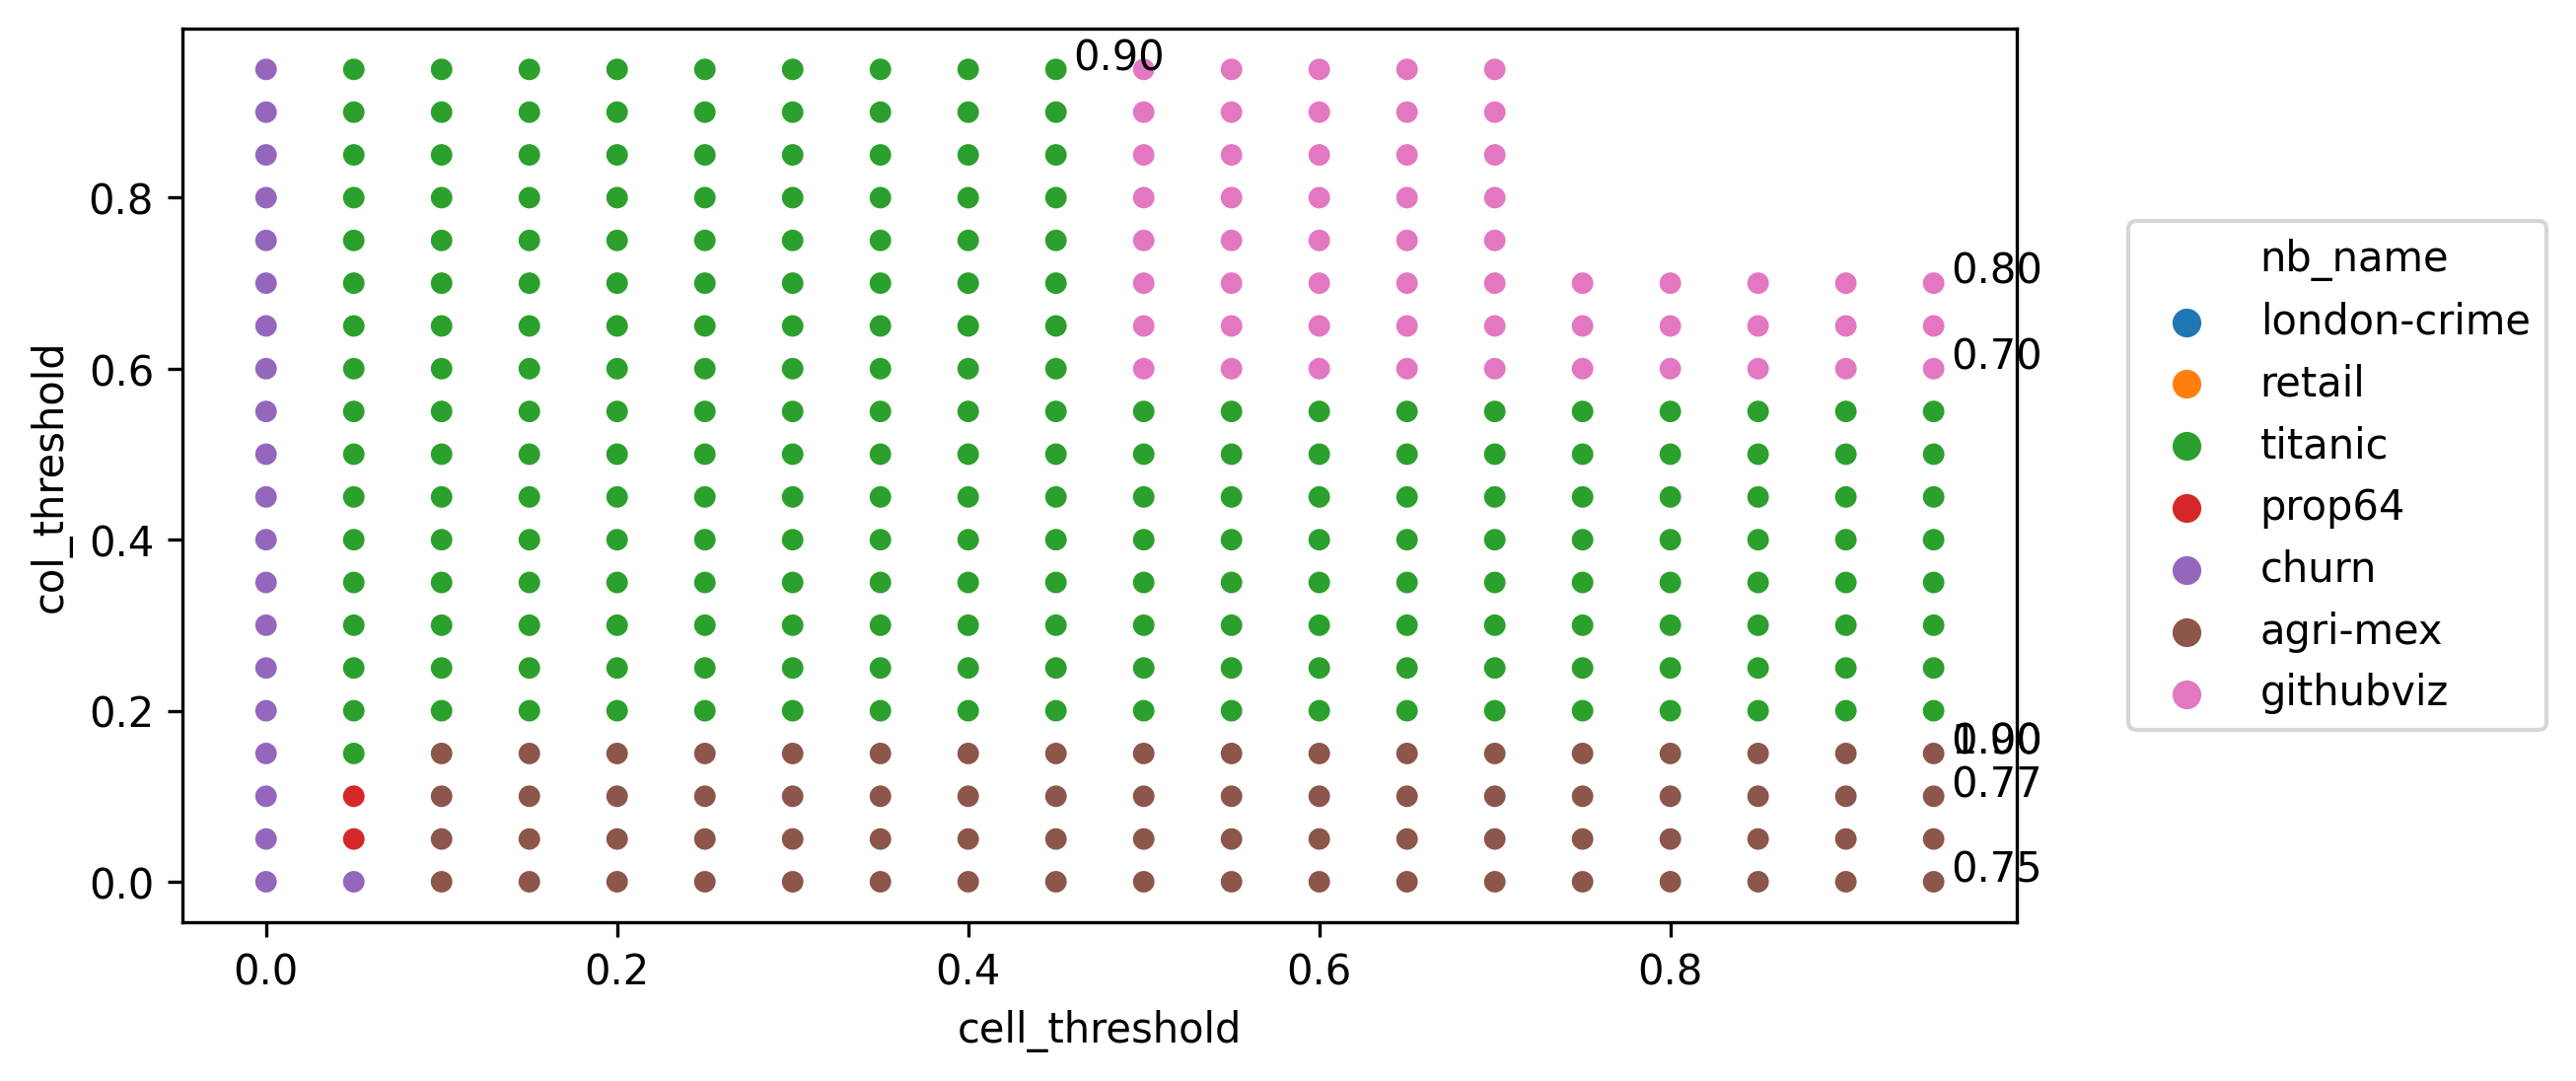

In [29]:
# library and dataset
import seaborn as sns
import matplotlib.pyplot as plt


fig = plt.figure(num=None, figsize=(8, 4), dpi=300, facecolor='w', edgecolor='k')

sns.scatterplot(x='cell_threshold', y='col_threshold', data=top_vals, hue='nb_name')


def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.01, point['y'], '{:.2f}'.format(point['val']))
        
    
label_point(top_vals3.cell_threshold, top_vals3.col_threshold, top_vals3.F1, plt.gca())  


plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)


interactive(children=(Dropdown(description='notebook', options=('london-crime', 'retail', 'titanic', 'prop64',…

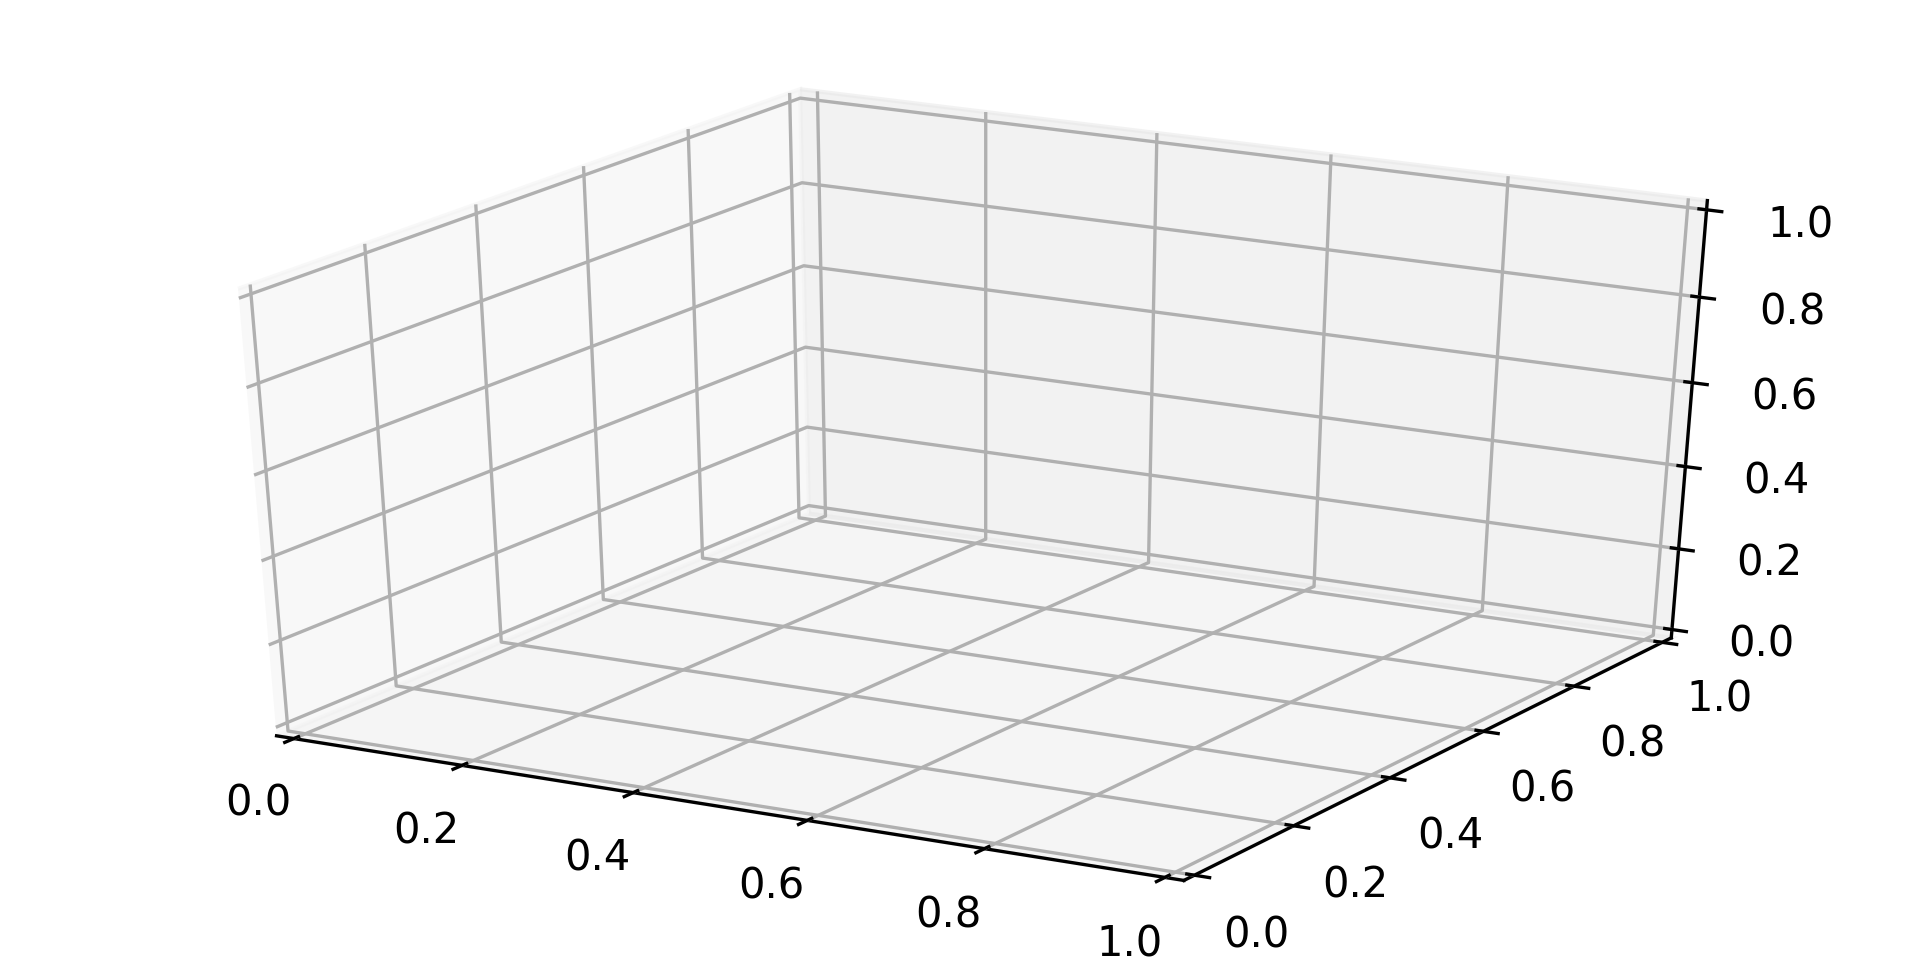

In [103]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets

def select_notebook(notebook=notebooks):
    #print(notebook)
    df=result.loc[result.nb_name == notebook]
    fig = plot_3d(df,notebook)


def plot_3d(df, notebook):
    fig = plt.figure(num=None, figsize=(8, 4), dpi=300, facecolor='w', edgecolor='k')
    ax = fig.gca(projection='3d')
    surf = ax.plot_trisurf(df['col_threshold'], df['cell_threshold'], df['F1'], cmap=plt.cm.viridis, linewidth=0.2)
    fig.colorbar( surf, shrink=0.5, aspect=5)
    ax.set_ylabel('col threshold')
    ax.set_xlabel('cell threshold')
    ax.set_zlabel('F1')
    plt.title('Threshold Curve for '+notebook)
    
    
    
    return fig

    
im = ipywidgets.interact_manual(select_notebook, notebook=notebooks)
